# Training and forecast example of an automated ARIMA model (TBATS).

In [1]:
from tbats import TBATS
import pandas as pd
from datetime import datetime
from sklearn.metrics import mean_squared_error as mse 
from sklearn.metrics import mean_absolute_percentage_error as mape
import numpy as np
from fbprophet import Prophet
import matplotlib.pyplot as plt
import statsmodels.api as sm

## Load dataset

In [2]:
ts60 = pd.read_csv('../VEOLIA/artifacts/timeseries_60min.csv', index_col=0, parse_dates=True)
load60 = ts60['Diff Load Activa Total (60 minuto)'].dropna()
load60.head()

datetime
2020-11-06 00:00:00    2600.0
2020-11-06 01:00:00    2610.0
2020-11-06 02:00:00    2570.0
2020-11-06 03:00:00    2580.0
2020-11-06 04:00:00    2600.0
Name: Diff Load Activa Total (60 minuto), dtype: float64

## Train / test split

In [3]:
train = load60[:datetime(2021, 6, 20)]
test = load60[datetime(2021, 6, 20):]

## Training TBATS

### Fit TBATS simple

In [5]:
# Fit the model
estimator = TBATS(seasonal_periods=(24, 168), n_jobs=6)
model = estimator.fit(train)
model.summary()

'Use Box-Cox: False\nUse trend: False\nUse damped trend: False\nSeasonal periods: [ 24. 168.]\nSeasonal harmonics [10  5]\nARMA errors (p, q): (4, 2)\nSmoothing (Alpha): 0.021652\nSeasonal Parameters (Gamma): [-1.11565396e-04  7.22198400e-05  5.02800514e-05 -1.28167751e-07]\nAR coefficients [ 5.02800514e-05 -1.28167751e-07  3.79674737e-01  4.30084121e-02]\nMA coefficients [0.51941709 0.39661608]\nSeed vector [ 2.95533046e+03 -2.22063920e+01 -9.35985599e+01  9.08837773e-01\n -6.03681782e+01  2.57953981e+01 -3.33008740e+00  1.68288787e+01\n  1.82575792e+01 -8.30822706e+00  3.50357295e+00 -2.36974551e+02\n  5.50933246e+00 -4.58600432e+01  3.32089662e+01  3.40215501e+01\n -1.10535597e+01  2.73278089e+01 -8.81188298e+00 -3.81189249e+00\n -1.73453730e+01 -3.25850380e+00 -4.47414591e+00  6.62397206e+00\n -1.31628758e+01 -2.33572461e+00  1.91250836e+01 -7.15409516e-01\n -2.45256706e+00 -1.77681334e+01 -5.07806641e+00  0.00000000e+00\n  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000

### Fit TBATS complex

In [6]:
# Fit the model
estimator = TBATS(seasonal_periods=(24, 168), n_jobs=6, use_box_cox=True, use_arma_errors=True, use_damped_trend=True, use_trend=True)
model_complex = estimator.fit(train)
model_complex.summary()

'Use Box-Cox: True\nUse trend: True\nUse damped trend: True\nSeasonal periods: [ 24. 168.]\nSeasonal harmonics [10  5]\nARMA errors (p, q): (0, 0)\nBox-Cox Lambda 1.000000\nSmoothing (Alpha): 0.662802\nTrend (Beta): -0.148360\nDamping Parameter (Phi): 0.800000\nSeasonal Parameters (Gamma): [-1.13053056e-06 -1.87272727e-06  1.85953822e-06  1.44366465e-06]\nAR coefficients []\nMA coefficients []\nSeed vector [ 2.07467248e+03  1.90498596e+02 -2.10261222e+01 -9.31429869e+01\n  1.23127676e+00 -6.00921755e+01  2.60500201e+01 -3.08692366e+00\n  1.70652896e+01  1.84897974e+01 -8.07865862e+00  3.73150140e+00\n -2.36889395e+02  5.55751636e+00 -4.58282792e+01  3.32318863e+01\n  3.40388426e+01 -1.10402644e+01  2.73380135e+01 -8.80419530e+00\n -3.80637566e+00 -1.73418008e+01  5.27051472e+01  7.71075073e+00\n  1.07011037e+01 -8.97289030e+00  2.91082657e-01  2.14772502e+01\n  4.85798398e+00 -1.38026846e+00 -1.72464571e+01 -2.98272615e+00]\n\nAIC 108468.499933'

## Day ahead forecasts

In [7]:
steps = 24
forecast = model.forecast(steps=steps)
forecast_complex = model_complex.forecast(steps=steps)

### Evaluation

In [8]:
print("Simple model:")
print("MAPE:", mape(test[:steps], forecast[:steps]))
print("MSE:", mse(test[:steps], forecast[:steps]))
print("RMSE:", np.sqrt(mse(test[:steps], forecast[:steps])))

print("Complex model:")
print("MAPE:", mape(test[:steps], forecast_complex[:steps]))
print("MSE:", mse(test[:steps], forecast_complex[:steps]))
print("RMSE:", np.sqrt(mse(test[:steps], forecast_complex[:steps])))

Simple model:
MAPE: 0.15152688326569883
MSE: 149291.02504299566
RMSE: 386.3819678025822
Complex model:
MAPE: 0.15556587841152034
MSE: 151357.02893338352
RMSE: 389.0463069268021


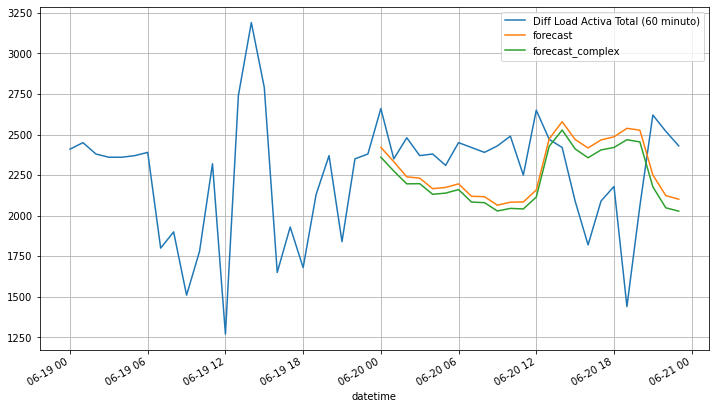

In [9]:
comparison = pd.DataFrame(test[:steps])
comparison['forecast'] = forecast
comparison['forecast_complex'] = forecast_complex
train = pd.DataFrame(train, columns=comparison.filter(like='Diff').columns.tolist())
comparison = pd.concat([train, comparison])
plt = comparison[datetime(2021, 6, 19):].plot(figsize=(12,7))
plt.grid()

## Training prophet
In this section facebook prophet is trained.

In [21]:
# add datetime as column for prophet
train_prophet = pd.DataFrame()
train_prophet['ds'] = train.index
train_prophet['y'] = train.values
# define the model
model_prophet = Prophet()
# fit the model
model_prophet.fit(train_prophet)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -44.6514


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       10483.2    0.00714846       1051.29      0.5763      0.5763      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       10505.8    0.00070365       107.255           1           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     244         10510   0.000301393       337.953   6.481e-07       0.001      346  LS failed, Hessian reset 
     299       10514.9   7.44461e-05       73.7932      0.7148      0.7148      414   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     311         10515   9.71775e-05       111.741   1.255e-06       0.001      472  LS failed, Hessian reset 
     399       10517.8    0.00404677       148.263           1           1      574   
    Iter      log prob        ||dx||      ||grad||       alpha

### Day-ahead forecast
An in sample forecast is produced and evaluated

MAPE: 0.20372118460747402
MSE: 252530.9324914722
RMSE: 502.52455909285885


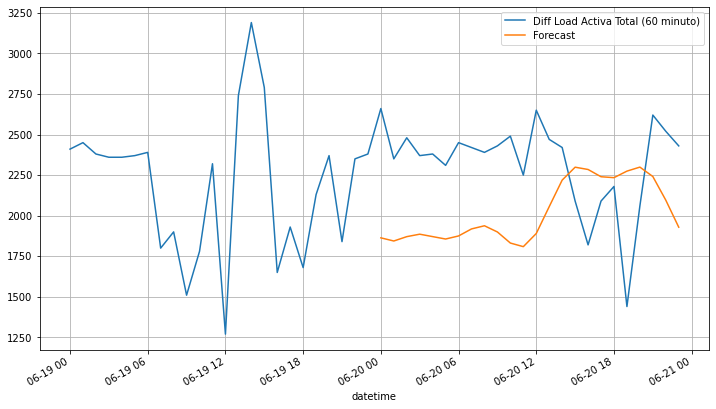

In [55]:
# evaluation
future = pd.DataFrame(test.index[:steps]).rename(columns={'datetime':'ds'})
forecast_prophet = model_prophet.predict(future)
predictions = forecast_prophet['yhat'].values
ground_truth = test[:steps]

print("MAPE:", mape(ground_truth, predictions))
print("MSE:", mse(ground_truth, predictions))
print("RMSE:", np.sqrt(mse(ground_truth, predictions)))

# plot forecast
comparison_prophet = pd.DataFrame(ground_truth)
comparison_prophet['Forecast'] = predictions
train = pd.DataFrame(train, columns=comparison_prophet.filter(like='Diff').columns.tolist())
comparison_prophet = pd.concat([train, comparison_prophet])
plt = comparison_prophet[datetime(2021, 6, 19):].plot(figsize=(12,7))
plt.grid()

Poor results of all models are probably due to seasonality. Howerver prophet is supposed to capture it.

## Seasonality detection

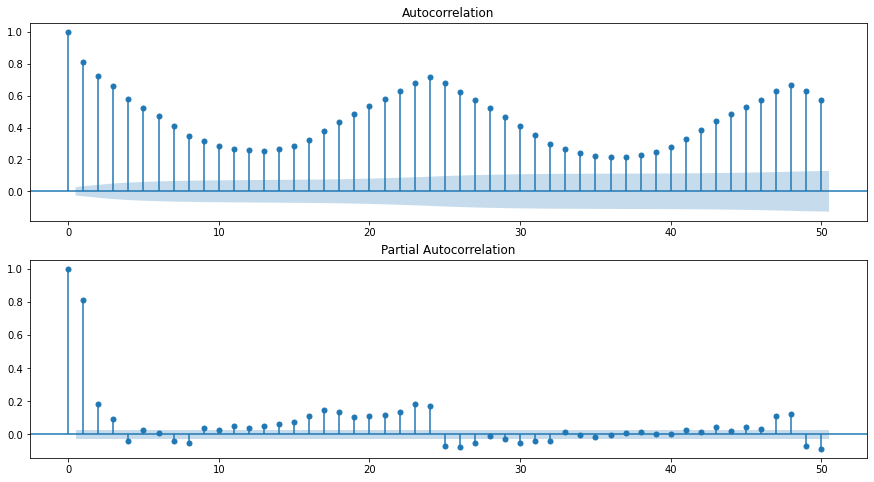

In [8]:
fig, ax = plt.subplots(2,1, figsize=(15, 8))
fig = sm.graphics.tsa.plot_acf(train, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(train, lags=50, ax=ax[1])
plt.show()

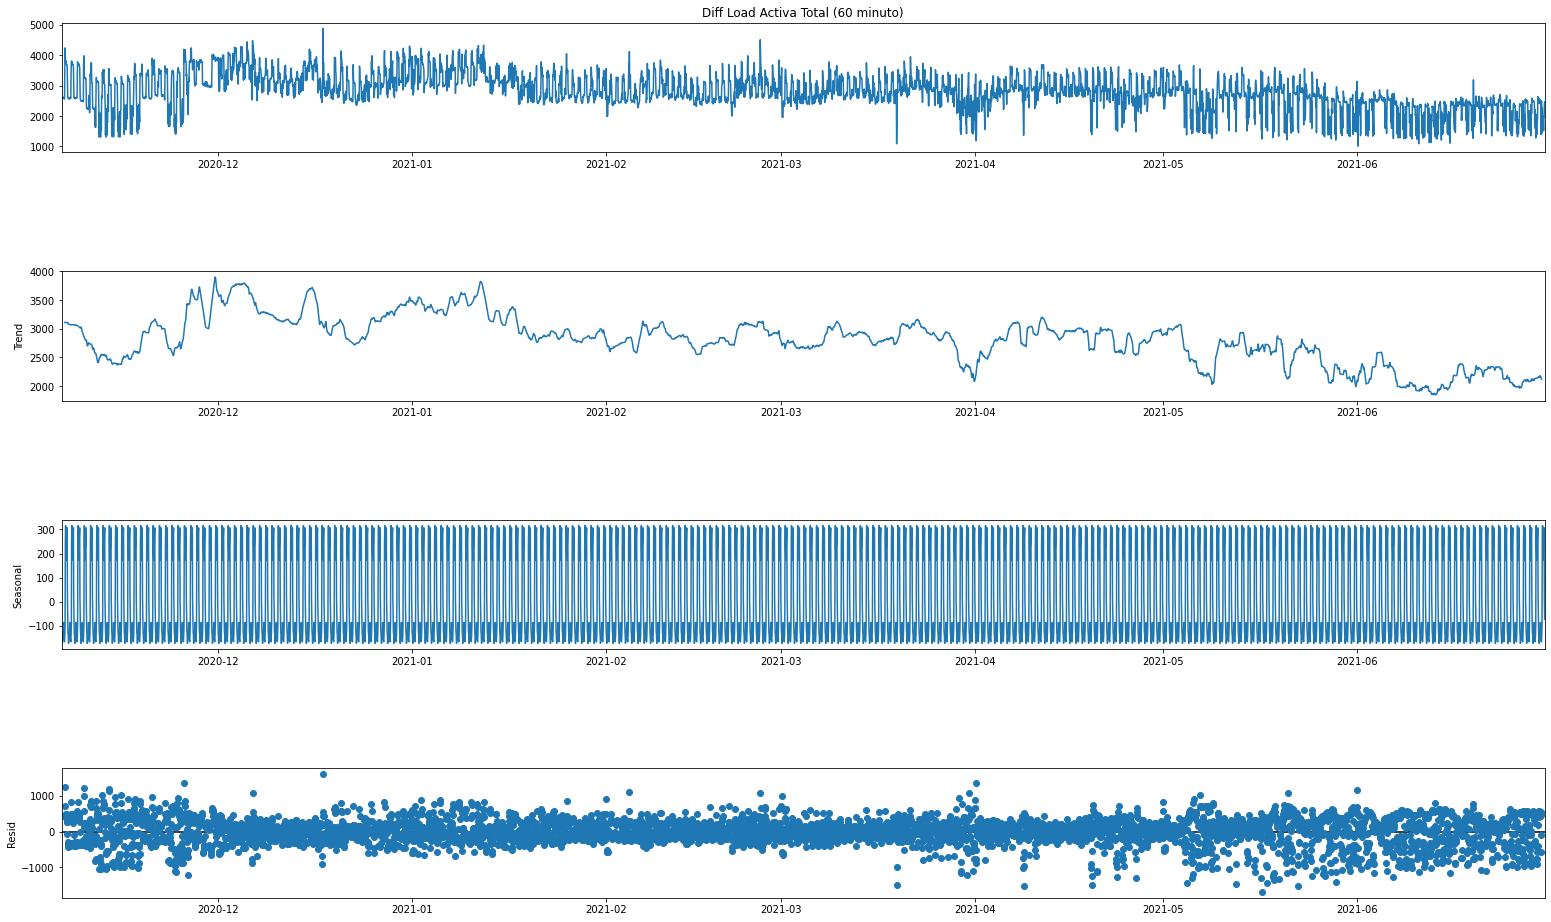

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(load60,  model='additive', period=24)
f = result.plot()
f.set_figheight(15)
f.set_figwidth(25)
plt.show()

Daily seasonality is obvious from all above plots. 
e.g. ACF is repeated every 24 timesteps.
Therefore a seasonal model will produce better results.

## Training SARIMA to capture seasonality

### Example sarima model
An example sarima is fit and the residuals ACF, PACFs are presented

/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


Optimization terminated successfully.
         Current function value: 7.058608
         Iterations: 2
         Function evaluations: 72


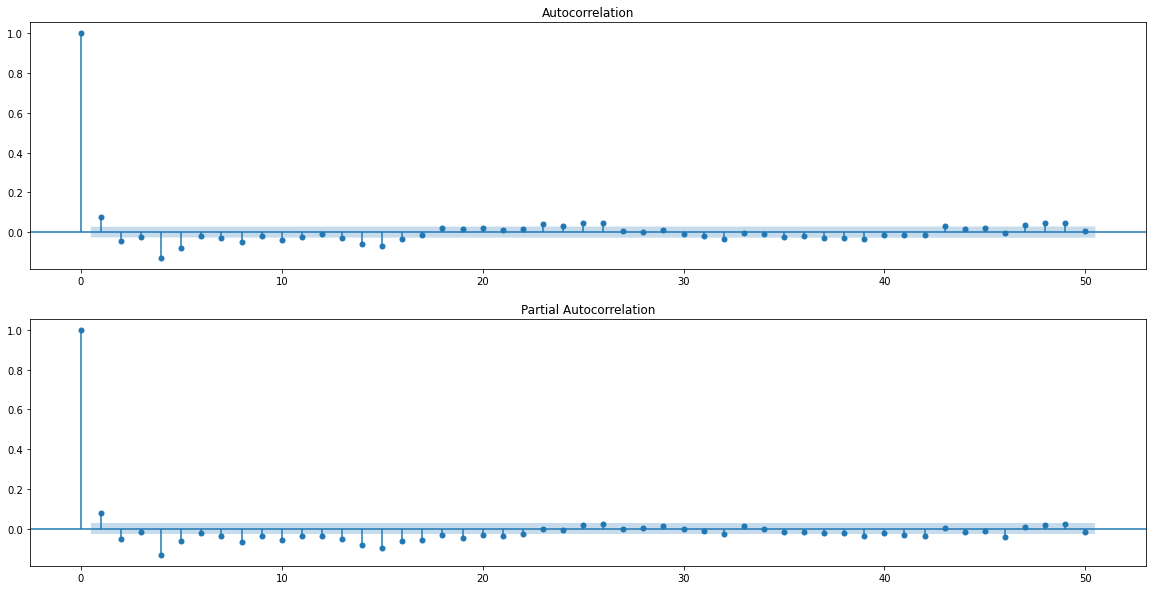

In [10]:
sarima = sm.tsa.statespace.SARIMAX(endog=train, order=(0,1,1), seasonal_order=(0,1,1,24)).fit(max_iter=50, method='powell')
res = sarima.resid
fig, ax = plt.subplots(2,1, figsize=(20, 10))
fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
plt.show()

Residuals seem much better so we proceed to a gridsearch in order to further improve the model.

In [11]:
import itertools
#set parameter range
p = range(0,3)
q = range(0,3)
d = range(0,2)
s = range(24, 25)
# list of all parameter combos
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(p, d, q, s))
# SARIMA model pipeline
results = {}
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                    order=param,
                                    seasonal_order=param_seasonal)
            results = mod.fit(max_iter = 50, method = 'powell')
            print('SARIMA{},{} - AIC:{}'.format(param, param_seasonal, results.aic))
            results[str(param) + '|' + str(param_seasonal)] = results.aic
        except:
            continue

/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


Optimization terminated successfully.
         Current function value: 9.391952
         Iterations: 1
         Function evaluations: 19
SARIMA(0, 0, 0),(0, 0, 0, 24) - AIC:101904.67381664432
Optimization terminated successfully.
         Current function value: 8.832349
         Iterations: 2
         Function evaluations: 52
SARIMA(0, 0, 0),(0, 0, 1, 24) - AIC:95834.98710990784


/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


Optimization terminated successfully.
         Current function value: 8.466116
         Iterations: 3
         Function evaluations: 128
SARIMA(0, 0, 0),(0, 0, 2, 24) - AIC:91863.35801080012


/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


Optimization terminated successfully.
         Current function value: 7.422733
         Iterations: 1
         Function evaluations: 10
SARIMA(0, 0, 0),(0, 1, 0, 24) - AIC:80538.64884782712


/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


Optimization terminated successfully.
         Current function value: 7.290377
         Iterations: 2
         Function evaluations: 47
SARIMA(0, 0, 0),(0, 1, 1, 24) - AIC:79104.59019186611


/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


Optimization terminated successfully.
         Current function value: 7.285147
         Iterations: 2
         Function evaluations: 66
SARIMA(0, 0, 0),(0, 1, 2, 24) - AIC:79049.84265398134


/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


Optimization terminated successfully.
         Current function value: 7.461442
         Iterations: 1
         Function evaluations: 22
SARIMA(0, 0, 0),(1, 0, 0, 24) - AIC:80960.64886926851


/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


Optimization terminated successfully.
         Current function value: 7.331869
         Iterations: 2
         Function evaluations: 74
SARIMA(0, 0, 0),(1, 0, 1, 24) - AIC:79556.77952201874


/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


Optimization terminated successfully.
         Current function value: 7.327281
         Iterations: 2
         Function evaluations: 95
SARIMA(0, 0, 0),(1, 0, 2, 24) - AIC:79508.99489209022


/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


Optimization terminated successfully.
         Current function value: 7.328563
         Iterations: 1
         Function evaluations: 23
SARIMA(0, 0, 0),(1, 1, 0, 24) - AIC:79518.90531842754


/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


Optimization terminated successfully.
         Current function value: 7.281282
         Iterations: 3
         Function evaluations: 110
SARIMA(0, 0, 0),(1, 1, 1, 24) - AIC:79007.91275928261


/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


Optimization terminated successfully.
         Current function value: 7.287406
         Iterations: 2
         Function evaluations: 98
SARIMA(0, 0, 0),(1, 1, 2, 24) - AIC:79076.35584612621


/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


Optimization terminated successfully.
         Current function value: 7.368574
         Iterations: 1
         Function evaluations: 33
SARIMA(0, 0, 0),(2, 0, 0, 24) - AIC:79955.02851334526


/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


Optimization terminated successfully.
         Current function value: 7.323490
         Iterations: 4
         Function evaluations: 193
SARIMA(0, 0, 0),(2, 0, 1, 24) - AIC:79467.86757442869


/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


Optimization terminated successfully.
         Current function value: 7.328815
         Iterations: 2
         Function evaluations: 120
SARIMA(0, 0, 0),(2, 0, 2, 24) - AIC:79527.64293958546


/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


Optimization terminated successfully.
         Current function value: 7.310486
         Iterations: 1
         Function evaluations: 35
SARIMA(0, 0, 0),(2, 1, 0, 24) - AIC:79324.77023306894


/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


Optimization terminated successfully.
         Current function value: 7.272369
         Iterations: 7
         Function evaluations: 328
SARIMA(0, 0, 0),(2, 1, 1, 24) - AIC:78913.20091013117


/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


Optimization terminated successfully.
         Current function value: 7.275780
         Iterations: 3
         Function evaluations: 174
SARIMA(0, 0, 0),(2, 1, 2, 24) - AIC:78952.2155760916


/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


Optimization terminated successfully.
         Current function value: 8.786711
         Iterations: 2
         Function evaluations: 56
SARIMA(0, 0, 1),(0, 0, 0, 24) - AIC:95339.81202339818


/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


Optimization terminated successfully.
         Current function value: 8.369686
         Iterations: 3
         Function evaluations: 130
SARIMA(0, 0, 1),(0, 0, 1, 24) - AIC:90817.09424027927


/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


Optimization terminated successfully.
         Current function value: 8.108241
         Iterations: 4
         Function evaluations: 210
SARIMA(0, 0, 1),(0, 0, 2, 24) - AIC:87982.41413937847


/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


Optimization terminated successfully.
         Current function value: 7.331937
         Iterations: 2
         Function evaluations: 45
SARIMA(0, 0, 1),(0, 1, 0, 24) - AIC:79555.51779803628


/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


Optimization terminated successfully.
         Current function value: 7.158660
         Iterations: 2
         Function evaluations: 72
SARIMA(0, 0, 1),(0, 1, 1, 24) - AIC:77677.45805962764


/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


Optimization terminated successfully.
         Current function value: 7.153539
         Iterations: 2
         Function evaluations: 89
SARIMA(0, 0, 1),(0, 1, 2, 24) - AIC:77623.89426468765


/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


Optimization terminated successfully.
         Current function value: 7.367843
         Iterations: 4
         Function evaluations: 161
SARIMA(0, 0, 1),(1, 0, 0, 24) - AIC:79947.09748015417


/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


Optimization terminated successfully.
         Current function value: 7.198518
         Iterations: 4
         Function evaluations: 201
SARIMA(0, 0, 1),(1, 0, 1, 24) - AIC:78111.92192299875


/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


Optimization terminated successfully.
         Current function value: 7.193777
         Iterations: 4
         Function evaluations: 256
SARIMA(0, 0, 1),(1, 0, 2, 24) - AIC:78062.4845632385


/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


Optimization terminated successfully.
         Current function value: 7.222547
         Iterations: 2
         Function evaluations: 71
SARIMA(0, 0, 1),(1, 1, 0, 24) - AIC:78370.63896418881


/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


Optimization terminated successfully.
         Current function value: 7.151650
         Iterations: 4
         Function evaluations: 189
SARIMA(0, 0, 1),(1, 1, 1, 24) - AIC:77603.39792849883


/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


Optimization terminated successfully.
         Current function value: 7.156032
         Iterations: 2
         Function evaluations: 116
SARIMA(0, 0, 1),(1, 1, 2, 24) - AIC:77652.94962209911


/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


Optimization terminated successfully.
         Current function value: 7.260427
         Iterations: 4
         Function evaluations: 212
SARIMA(0, 0, 1),(2, 0, 0, 24) - AIC:78783.62932373115


/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


Optimization terminated successfully.
         Current function value: 7.192820
         Iterations: 6
         Function evaluations: 382
SARIMA(0, 0, 1),(2, 0, 1, 24) - AIC:78052.09684483564


/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


Optimization terminated successfully.
         Current function value: 7.195937
         Iterations: 4
         Function evaluations: 293
SARIMA(0, 0, 1),(2, 0, 2, 24) - AIC:78087.91584922577


/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


Optimization terminated successfully.
         Current function value: 7.194514
         Iterations: 2
         Function evaluations: 94
SARIMA(0, 0, 1),(2, 1, 0, 24) - AIC:78068.47692902127


/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


Optimization terminated successfully.
         Current function value: 7.146315
         Iterations: 5
         Function evaluations: 304
SARIMA(0, 0, 1),(2, 1, 1, 24) - AIC:77547.51560357116


/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


Optimization terminated successfully.
         Current function value: 7.148804
         Iterations: 3
         Function evaluations: 210
SARIMA(0, 0, 1),(2, 1, 2, 24) - AIC:77576.5283378984


/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


Optimization terminated successfully.
         Current function value: 8.388139
         Iterations: 3
         Function evaluations: 112
SARIMA(0, 0, 2),(0, 0, 0, 24) - AIC:91017.30709684835


/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


Optimization terminated successfully.
         Current function value: 8.114099
         Iterations: 4
         Function evaluations: 221
SARIMA(0, 0, 2),(0, 0, 1, 24) - AIC:88045.97385993638


/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


Optimization terminated successfully.
         Current function value: 7.936939
         Iterations: 4
         Function evaluations: 252
SARIMA(0, 0, 2),(0, 0, 2, 24) - AIC:86125.78782614415


/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


Optimization terminated successfully.
         Current function value: 7.312965
         Iterations: 2
         Function evaluations: 67
SARIMA(0, 0, 2),(0, 1, 0, 24) - AIC:79351.66627989552


/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


Optimization terminated successfully.
         Current function value: 7.120558
         Iterations: 3
         Function evaluations: 137
SARIMA(0, 0, 2),(0, 1, 1, 24) - AIC:77266.056048159


/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


Optimization terminated successfully.
         Current function value: 7.116752
         Iterations: 2
         Function evaluations: 114
SARIMA(0, 0, 2),(0, 1, 2, 24) - AIC:77226.76135095413


/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


Optimization terminated successfully.
         Current function value: 7.347253
         Iterations: 4
         Function evaluations: 196
SARIMA(0, 0, 2),(1, 0, 0, 24) - AIC:79725.6983342667


/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


Optimization terminated successfully.
         Current function value: 7.159475
         Iterations: 4
         Function evaluations: 253
SARIMA(0, 0, 2),(1, 0, 1, 24) - AIC:77690.30621673429


/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


Optimization terminated successfully.
         Current function value: 7.155945
         Iterations: 4
         Function evaluations: 292
SARIMA(0, 0, 2),(1, 0, 2, 24) - AIC:77654.00060404782


/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


Optimization terminated successfully.
         Current function value: 7.194615
         Iterations: 2
         Function evaluations: 93
SARIMA(0, 0, 2),(1, 1, 0, 24) - AIC:78069.57543427747


/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


Optimization terminated successfully.
         Current function value: 7.115678
         Iterations: 4
         Function evaluations: 234
SARIMA(0, 0, 2),(1, 1, 1, 24) - AIC:77215.10394834334


/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


Optimization terminated successfully.
         Current function value: 7.118890
         Iterations: 3
         Function evaluations: 205
SARIMA(0, 0, 2),(1, 1, 2, 24) - AIC:77251.95869790603


/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


Optimization terminated successfully.
         Current function value: 7.231177
         Iterations: 4
         Function evaluations: 250
SARIMA(0, 0, 2),(2, 0, 0, 24) - AIC:78468.27137944056


/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


Optimization terminated successfully.
         Current function value: 7.154766
         Iterations: 5
         Function evaluations: 376
SARIMA(0, 0, 2),(2, 0, 1, 24) - AIC:77641.21381610681


/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


Optimization terminated successfully.
         Current function value: 7.157884
         Iterations: 4
         Function evaluations: 345
SARIMA(0, 0, 2),(2, 0, 2, 24) - AIC:77677.04428630738


/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


Optimization terminated successfully.
         Current function value: 7.163774
         Iterations: 2
         Function evaluations: 118
SARIMA(0, 0, 2),(2, 1, 0, 24) - AIC:77736.94520164971


/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


Optimization terminated successfully.
         Current function value: 7.110791
         Iterations: 6
         Function evaluations: 416
SARIMA(0, 0, 2),(2, 1, 1, 24) - AIC:77164.07692987003


/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


Optimization terminated successfully.
         Current function value: 7.113007
         Iterations: 3
         Function evaluations: 242
SARIMA(0, 0, 2),(2, 1, 2, 24) - AIC:77190.12849135461
Optimization terminated successfully.
         Current function value: 7.258553
         Iterations: 1
         Function evaluations: 10


/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 1, 0),(0, 0, 0, 24) - AIC:78757.29607432798


/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


Optimization terminated successfully.
         Current function value: 7.240809
         Iterations: 1
         Function evaluations: 23
SARIMA(0, 1, 0),(0, 0, 1, 24) - AIC:78566.77621512114


/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


Optimization terminated successfully.
         Current function value: 7.227547
         Iterations: 2
         Function evaluations: 66
SARIMA(0, 1, 0),(0, 0, 2, 24) - AIC:78424.88573138336
Optimization terminated successfully.
         Current function value: 7.448035
         Iterations: 1
         Function evaluations: 9


/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


SARIMA(0, 1, 0),(0, 1, 0, 24) - AIC:80813.18122860623


/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


Optimization terminated successfully.
         Current function value: 7.163152
         Iterations: 2
         Function evaluations: 46
SARIMA(0, 1, 0),(0, 1, 1, 24) - AIC:77724.20060147054


/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


Optimization terminated successfully.
         Current function value: 7.162504
         Iterations: 2
         Function evaluations: 66


### Day ahead forecast 

In [30]:
sarima = sm.tsa.statespace.SARIMAX(train, order=(0,0,2), 
                                   seasonal_order=(2,1,1,24)).fit(max_iter = 50,
                                                                  method = 'powell')
print('AIC: ', sarima.aic)

/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


Optimization terminated successfully.
         Current function value: 7.110791
         Iterations: 6
         Function evaluations: 416
AIC:  77164.07692987003


MAPE: 0.11360908071356092
MSE: 104379.56111525022
RMSE: 323.07825849977934


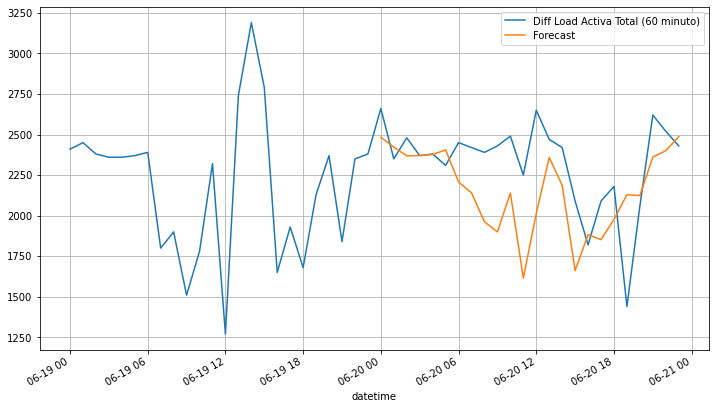

In [31]:
# Forecast next day hourly loads
forecast_sarima = sarima.get_forecast(steps=steps)
predictions = forecast_sarima.summary_frame()['mean'].values
ground_truth = test[:steps]

print("MAPE:", mape(ground_truth, predictions))
print("MSE:", mse(ground_truth, predictions))
print("RMSE:", np.sqrt(mse(ground_truth, predictions)))

# plot forecast
comparison_sarima = pd.DataFrame(ground_truth)
comparison_sarima['Forecast'] = predictions
train = pd.DataFrame(train, columns=comparison_sarima.filter(like='Diff').columns.tolist())
comparison_sarima = pd.concat([train, comparison_sarima])
plt = comparison_sarima[datetime(2021, 6, 19):].plot(figsize=(12,7))
plt.grid()

